In [1]:
import os, csv
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [28]:
NUM_IMGS_FOR_EACH_CLASS = 100

class NumbersDataset(Dataset):
    def __init__(self, data_folder):
        self.fnames = []
        for (root, dirs, files) in os.walk(data_folder):
            for idx, filename in enumerate(files):
                if idx == NUM_IMGS_FOR_EACH_CLASS:
                    break
                self.fnames.append(os.path.join(root, filename))

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        filename = self.fnames[idx]
        img = Image.open(filename).convert('L')
        img_as_np = np.asarray(img)
        img_as_np = img_as_np.reshape(1,28,28)
        sample = {'img': img_as_np, 'label': int(filename.split('/')[-2].split('_')[-1])}
        return sample

In [29]:
valid_folder = 'hw2_data/hw2-3_data/valid'
valid_dataset = NumbersDataset(valid_folder)
valid_dataloader = DataLoader(valid_dataset, batch_size=9999)

In [4]:
class NumberClassifier(nn.Module):
    def __init__(self):
        super(NumberClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        conv1_output = self.conv1(x)
        x = F.relu(F.max_pool2d(conv1_output, 2))
        conv2_output = self.conv2(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(conv2_output), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return (conv1_output, conv2_output, F.log_softmax(x, dim=1))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NumberClassifier().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()
for param in model.parameters():
    param.requires_grad = False

#### visualize filters: should gradients be constants? why do different gradients lead to same output after optimizer.step()?

In [22]:
NUM_ITERATIONS = 10 # only need to run once? gradients will not change?

for filter_idx in range(6):
    input_img = torch.zeros(1,1,28,28).to(device)
    # input_img = torch.Tensor(np.random.random((1, 1, 28, 28)) * 20 + 128).to(device)
    input_img.requires_grad = True
    print('input_grad before any calculation:', (input_img.grad))

    optimizer = optim.Adam(iter([input_img]))
    for iteration in range(NUM_ITERATIONS):
        optimizer.zero_grad()
        conv1_output, conv2_output, log_softmax = model(input_img)
        loss = -torch.sum(conv1_output[0][filter_idx])
        loss.backward()
        print()
#         print('input_img.grad.mean():', abs(input_img.grad).mean())
        print('input_img.grad:', input_img.grad[0][0][0][:5])
        print('input_img before step():', input_img[0][0][0][:5])
        optimizer.step()
        print('input_img after step():', input_img[0][0][0][:5])
    print("=======================")
    
    # img_np = np.array(input_img.data[0][0])
    img_np = np.array(input_img.grad[0][0])
    pixel_range = img_np.max() - img_np.min()
    pixel_delta = img_np - img_np.min()
    pixel_normalized = pixel_delta * 255 / pixel_range
    im = Image.fromarray(pixel_normalized.astype('uint8'))
    im.save("conv1_grad_{}.jpg".format(filter_idx))

input_grad before any calculation: None

input_img.grad: tensor([0.2458, 0.2921, 0.4179, 0.7269, 0.8870])
input_img before step(): tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward>)
input_img after step(): tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010], grad_fn=<SliceBackward>)

input_img.grad: tensor([0.2458, 0.2921, 0.4179, 0.7269, 0.8870])
input_img before step(): tensor([-0.0010, -0.0010, -0.0010, -0.0010, -0.0010], grad_fn=<SliceBackward>)
input_img after step(): tensor([-0.0020, -0.0020, -0.0020, -0.0020, -0.0020], grad_fn=<SliceBackward>)

input_img.grad: tensor([0.2458, 0.2921, 0.4179, 0.7269, 0.8870])
input_img before step(): tensor([-0.0020, -0.0020, -0.0020, -0.0020, -0.0020], grad_fn=<SliceBackward>)
input_img after step(): tensor([-0.0030, -0.0030, -0.0030, -0.0030, -0.0030], grad_fn=<SliceBackward>)

input_img.grad: tensor([0.2458, 0.2921, 0.4179, 0.7269, 0.8870])
input_img before step(): tensor([-0.0030, -0.0030, -0.0030, -0.0030, -0.0030], grad_fn=<SliceBackwar

#### t-SNE

In [37]:
# only need to run 1 batch here
for batch in valid_dataloader:
    imgs, labels = batch['img'].to(device), batch['label'].to(device)
    imgs = imgs.float() / 255
    (conv1_output, conv2_output, log_softmax) = model(imgs)
    print(conv1_output.shape)
    print(conv2_output.shape)
    print(labels.shape)
    break

torch.Size([1000, 10, 24, 24])
torch.Size([1000, 20, 8, 8])
torch.Size([1000])


In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools
import matplotlib.pyplot as plt

In [71]:
list_of_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

In [72]:
pca = PCA(n_components=50)
low_level_output = np.array(conv1_output).reshape(1000,-1)
pca.fit(low_level_output)
low_level_output_pca = pca.transform(low_level_output)
imgs_tsne = TSNE(n_components=2).fit_transform(low_level_output_pca)

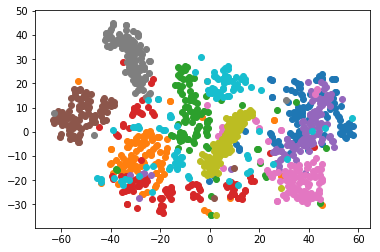

In [74]:
color_cycler = itertools.cycle(list_of_colors)
for idx, thing in enumerate(imgs_tsne):
    if idx%100 == 0:
        chosen_color = next(color_cycler)
    plt.scatter(thing[0], thing[1], color=chosen_color)
# myplot = plt.scatter(imgs_tsne[:,0], imgs_tsne[:,1], color=next(colors))
plt.savefig('low_level_tsne.png', dpi=150)

In [75]:
pca = PCA(n_components=50)
high_level_output = np.array(conv2_output).reshape(1000,-1)
pca.fit(high_level_output)
high_level_output_pca = pca.transform(high_level_output)
imgs_tsne = TSNE(n_components=2).fit_transform(high_level_output_pca)

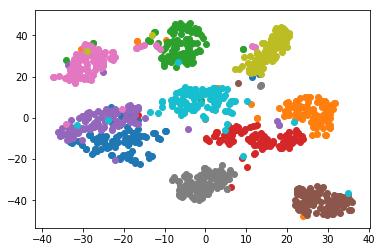

In [76]:
color_cycler = itertools.cycle(list_of_colors)
for idx, thing in enumerate(imgs_tsne):
    if idx%100 == 0:
        chosen_color = next(color_cycler)
    plt.scatter(thing[0], thing[1], color=chosen_color)
# myplot = plt.scatter(imgs_tsne[:,0], imgs_tsne[:,1], color=next(colors))
plt.savefig('high_level_tsne.png', dpi=150)